In [34]:
# 한글 폰트 설치, ! 명령어는 코랩에서 시스템 명령어를 실행하게 해준다.
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

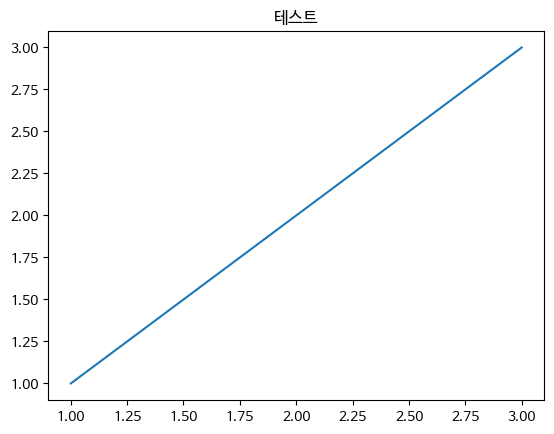

In [35]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 폰트 경로를 지정한다.
font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'  # 예시 경로
# 폰트 이름을 가져온다.
font_name = fm.FontProperties(fname=font_path, size=10).get_name()
# Matplotlib의 rcParams에 폰트를 지정한다.
plt.rcParams['font.family'] = font_name

# 테스트용 그래프를 그린다.
plt.figure()
plt.plot([1, 2, 3], [1, 2, 3])
plt.title('테스트')
plt.show()

In [28]:
import pandas as pd

# Load the data from the uploaded Excel file
file_path = '/content/sample_data/시계열분석_복합SCFI_2017.xlsx'
data = pd.read_excel(file_path)

# Display the first few rows of the dataframe to understand its structure
data.head()


,YYYYMM,SCFI_C
0,2014-01,1174.866
1,2014-02,1069.362
2,2014-03,969.145
3,2014-04,1078.462
4,2014-05,1137.112


In [29]:
from sklearn.model_selection import train_test_split
import numpy as np

# 데이터 전처리: YYYYMM 컬럼을 datetime 형식으로 변환
data['YYYYMM'] = pd.to_datetime(data['YYYYMM'])

# 상대적 시간 변수 추가(A안)
data['RelativeTime'] = np.arange(len(data))

# 년과 월을 별도로 분리(C안, D안)
data['Year'] = data['YYYYMM'].dt.year
data['Month'] = data['YYYYMM'].dt.month

# 절대적 시간 변수는 YYYYMM 그대로 사용(B안)

# 다항 회귀를 위한 2차 항 추가(E안)
data['RelativeTimeSquared'] = data['RelativeTime'] ** 2

# 데이터를 학습 데이터와 테스트 데이터로 분리 (마지막 6개월)
train_data = data.iloc[:-6]
test_data = data.iloc[-6:]

# 종속 변수
y_train = train_data['SCFI_C']
y_test = test_data['SCFI_C']

# 독립 변수 준비
# A안 상대적 시간 변수
X_train_relative = train_data[['RelativeTime']]
X_test_relative = test_data[['RelativeTime']]
# B안 절대적 시간 변수
X_train_absolute = train_data[['YYYYMM']].apply(lambda x: x.dt.strftime('%Y%m').astype(int))
X_test_absolute = test_data[['YYYYMM']].apply(lambda x: x.dt.strftime('%Y%m').astype(int))
# C안 년과 월을 별도로 사용
X_train_year_month = train_data[['Year', 'Month']]
X_test_year_month = test_data[['Year', 'Month']]
# D안 월만 사용
X_train_month = train_data[['Month']]
X_test_month = test_data[['Month']]
# E안 다항회귀(2차 다항식)
X_train_poly = train_data[['RelativeTime', 'RelativeTimeSquared']]
X_test_poly = test_data[['RelativeTime', 'RelativeTimeSquared']]

In [30]:
# 모델링을 위한 함수 정의
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def train_and_evaluate(X_train, X_test, y_train, y_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    return model, rmse

# 각 방법별 모델 훈련 및 평가
results = {}

# 상대적 시간 변수
model_relative, rmse_relative = train_and_evaluate(X_train_relative, X_test_relative, y_train, y_test)
results['Relative Time Variable'] = {'Model': model_relative, 'RMSE': rmse_relative}

# 절대적 시간 변수
model_absolute, rmse_absolute = train_and_evaluate(X_train_absolute, X_test_absolute, y_train, y_test)
results['Absolute Time Variable'] = {'Model': model_absolute, 'RMSE': rmse_absolute}

# 년과 월을 별도로 사용
model_year_month, rmse_year_month = train_and_evaluate(X_train_year_month, X_test_year_month, y_train, y_test)
results['Year and Month Separately'] = {'Model': model_year_month, 'RMSE': rmse_year_month}

# 월만 사용
model_month, rmse_month = train_and_evaluate(X_train_month, X_test_month, y_train, y_test)
results['Using Only Month'] = {'Model': model_month, 'RMSE': rmse_month}

# 다항 회귀 (2차 다항식)
model_poly, rmse_poly = train_and_evaluate(X_train_poly, X_test_poly, y_train, y_test)
results['Polynomial Regression (2nd Degree)'] = {'Model': model_poly, 'RMSE': rmse_poly}

results


{'Relative Time Variable': {'Model': LinearRegression(),
  'RMSE': 300.30575430301553},
 'Absolute Time Variable': {'Model': LinearRegression(),
  'RMSE': 280.9279881260861},
 'Year and Month Separately': {'Model': LinearRegression(),
  'RMSE': 299.10913349430496},
 'Using Only Month': {'Model': LinearRegression(), 'RMSE': 45.54416418343694},
 'Polynomial Regression (2nd Degree)': {'Model': LinearRegression(),
  'RMSE': 119.82722637115414}}

In [31]:
# 결과를 테이블 형태로 정리
results_df = pd.DataFrame({
    '모델링 접근법': [
        '상대적 시간 변수',
        '절대적 시간 변수',
        '년과 월을 별도로 사용',
        '월만 사용',
        '다항 회귀 (2차 다항식)'
    ],
    'RMSE': [
        results['Relative Time Variable']['RMSE'],
        results['Absolute Time Variable']['RMSE'],
        results['Year and Month Separately']['RMSE'],
        results['Using Only Month']['RMSE'],
        results['Polynomial Regression (2nd Degree)']['RMSE']
    ],
    '모델식': [
        'SCFI_C = β0 + β1 * RelativeTime',
        'SCFI_C = β0 + β1 * YYYYMM',
        'SCFI_C = β0 + β1 * Year + β2 * Month',
        'SCFI_C = β0 + β1 * Month',
        'SCFI_C = β0 + β1 * RelativeTime + β2 * RelativeTime^2'
    ]
})

results_df

,모델링 접근법,RMSE,모델식
0,상대적 시간 변수,300.305754,SCFI_C = β0 + β1 * RelativeTime
1,절대적 시간 변수,280.927988,SCFI_C = β0 + β1 * YYYYMM
2,년과 월을 별도로 사용,299.109133,SCFI_C = β0 + β1 * Year + β2 * Month
3,월만 사용,45.544164,SCFI_C = β0 + β1 * Month
4,다항 회귀 (2차 다항식),119.827226,SCFI_C = β0 + β1 * RelativeTime + β2 * Relativ...


In [32]:
# 각 모델의 회귀계수 추출
coefficients = {
    'Relative Time Variable': model_relative.coef_,
    'Absolute Time Variable': model_absolute.coef_,
    'Year and Month Separately': model_year_month.coef_,
    'Using Only Month': model_month.coef_,
    'Polynomial Regression (2nd Degree)': model_poly.coef_
}

intercepts = {
    'Relative Time Variable': model_relative.intercept_,
    'Absolute Time Variable': model_absolute.intercept_,
    'Year and Month Separately': model_year_month.intercept_,
    'Using Only Month': model_month.intercept_,
    'Polynomial Regression (2nd Degree)': model_poly.intercept_
}

# 모델식을 테이블 형태로 정리
model_formulas = []

# 각 모델의 회귀계수와 절편을 사용하여 모델식을 작성
for model_name in coefficients.keys():
    coef = coefficients[model_name]
    intercept = intercepts[model_name]

    if model_name == 'Relative Time Variable':
        formula = f"SCFI_C = {intercept:.3f} + {coef[0]:.3f} * RelativeTime"
    elif model_name == 'Absolute Time Variable':
        formula = f"SCFI_C = {intercept:.3f} + {coef[0]:.3f} * YYYYMM"
    elif model_name == 'Year and Month Separately':
        formula = f"SCFI_C = {intercept:.3f} + {coef[0]:.3f} * Year + {coef[1]:.3f} * Month"
    elif model_name == 'Using Only Month':
        formula = f"SCFI_C = {intercept:.3f} + {coef[0]:.3f} * Month"
    elif model_name == 'Polynomial Regression (2nd Degree)':
        formula = f"SCFI_C = {intercept:.3f} + {coef[0]:.3f} * RelativeTime + {coef[1]:.3f} * RelativeTime^2"

    model_formulas.append(formula)

# 결과 테이블 작성
results_with_coefficients = pd.DataFrame({
    '모델링 접근법': [
        '상대적 시간 변수',
        '절대적 시간 변수',
        '년과 월을 별도로 사용',
        '월만 사용',
        '다항 회귀 (2차 다항식)'
    ],
    'RMSE': [
        round(results['Relative Time Variable']['RMSE'], 3),
        round(results['Absolute Time Variable']['RMSE'], 3),
        round(results['Year and Month Separately']['RMSE'], 3),
        round(results['Using Only Month']['RMSE'], 3),
        round(results['Polynomial Regression (2nd Degree)']['RMSE'], 3)
    ],
    '모델식': model_formulas
})

results_with_coefficients


,모델링 접근법,RMSE,모델식
0,상대적 시간 변수,300.306,SCFI_C = 1050.824 + -12.150 * RelativeTime
1,절대적 시간 변수,280.928,SCFI_C = 277004.986 + -1.370 * YYYYMM
2,년과 월을 별도로 사용,299.109,SCFI_C = 292408.051 + -144.653 * Year + -14.57...
3,월만 사용,45.544,SCFI_C = 864.117 + -7.175 * Month
4,다항 회귀 (2차 다항식),119.827,SCFI_C = 1286.382 + -50.349 * RelativeTime + 1...


In [33]:
# 예측 결과 계산
test_data['Pred_Relative'] = model_relative.predict(X_test_relative)
test_data['Pred_Absolute'] = model_absolute.predict(X_test_absolute)
test_data['Pred_Year_Month'] = model_year_month.predict(X_test_year_month)
test_data['Pred_Month'] = model_month.predict(X_test_month)
test_data['Pred_Poly'] = model_poly.predict(X_test_poly)

# 테스트 데이터의 예측 결과를 포함한 데이터프레임 생성
predictions_df = test_data[['YYYYMM', 'SCFI_C', 'Pred_Relative', 'Pred_Absolute', 'Pred_Year_Month', 'Pred_Month', 'Pred_Poly']]

# 결과 출력
print(predictions_df)


       YYYYMM   SCFI_C  Pred_Relative  Pred_Absolute  Pred_Year_Month  \
39 2017-04-01  834.060     576.958130     569.902840       584.309074   
40 2017-05-01  860.922     564.807728     568.532342       569.732861   
41 2017-06-01  869.764     552.657327     567.161843       555.156648   
42 2017-07-01  878.540     540.506926     565.791344       540.580435   
43 2017-08-01  864.205     528.356525     564.420845       526.004222   
44 2017-09-01  760.540     516.206123     563.050347       511.428010   

    Pred_Month    Pred_Poly  
39  835.418930   851.720483  
40  828.244427   880.784435  
41  821.069924   911.858843  
42  813.895420   944.943707  
43  806.720917   980.039028  
44  799.546414  1017.144805  


<ipython-input-33-52665245a61f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Pred_Relative'] = model_relative.predict(X_test_relative)
<ipython-input-33-52665245a61f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Pred_Absolute'] = model_absolute.predict(X_test_absolute)
<ipython-input-33-52665245a61f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

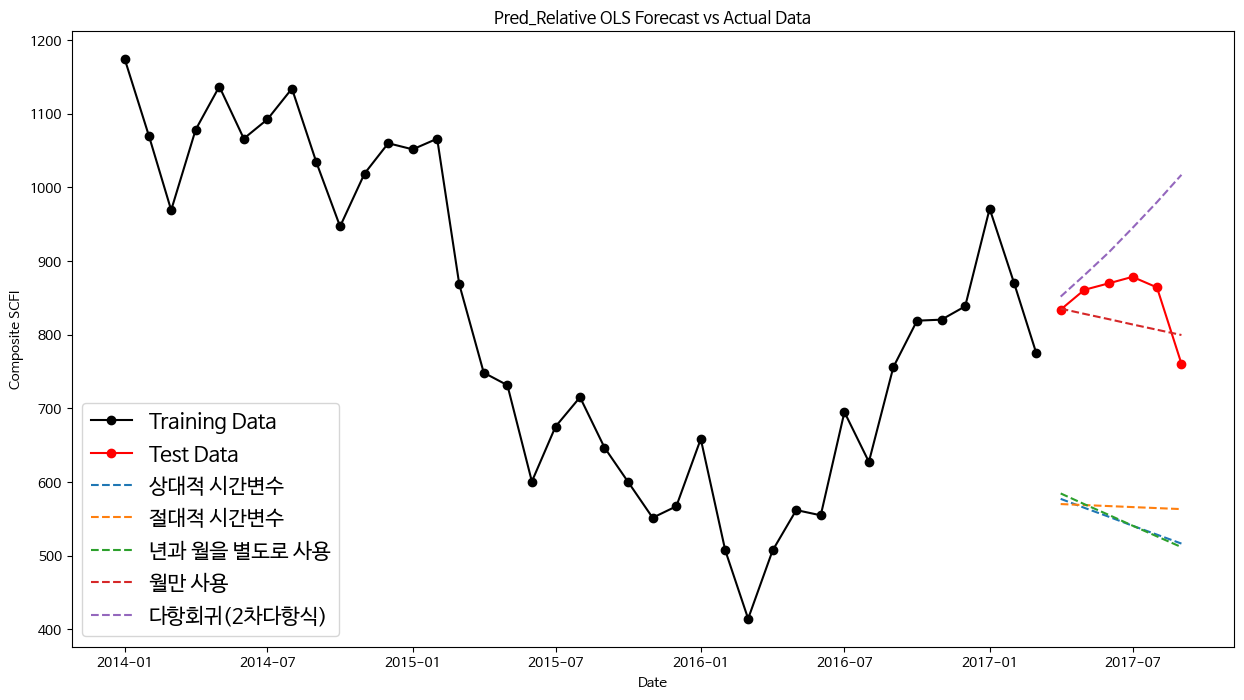

In [36]:
import matplotlib.pyplot as plt
train_data.set_index('YYYYMM', inplace=True)
test_data.set_index('YYYYMM', inplace=True)
# Plotting the results
plt.figure(figsize=(15, 8))
plt.plot(train_data.index, train_data['SCFI_C'], label='Training Data', color='black', marker='o')
plt.plot(test_data.index, test_data['SCFI_C'], label='Test Data', color='red', marker='o')
plt.plot(test_data.index, test_data['Pred_Relative'], label='상대적 시간변수', linestyle='--')
plt.plot(test_data.index, test_data['Pred_Absolute'], label='절대적 시간변수', linestyle='--')
plt.plot(test_data.index, test_data['Pred_Year_Month'], label='년과 월을 별도로 사용', linestyle='--' )
plt.plot(test_data.index, test_data['Pred_Month'], label='월만 사용', linestyle='--')
plt.plot(test_data.index, test_data['Pred_Poly'], label='다항회귀(2차다항식)', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Composite SCFI')
plt.title('Pred_Relative OLS Forecast vs Actual Data')
plt.legend(fontsize=15)
plt.show()